In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg as lg 
import numdifftools as nd

In [13]:
N=256
Ns=N//3
L=4.

grid=(np.linspace(1/(2*N),(2*N-1)/(2*N),N)*np.pi)
grid=L*np.cos(grid)/np.sin(grid)

In [14]:
h1=np.tri(Ns,M=Ns,k=-3)*2
h1[::2,::2]*=-1
h1[1::2,1::2]*=-1
h1+=np.diag(-np.ones(Ns))+np.diag(np.ones(Ns-1)*13/8,-1)-np.diag(np.ones(Ns-2)*31/16,-2)
h1+=np.diag(np.ones(Ns-1)*3/8,1)-np.diag(np.ones(Ns-2)/16,2)
h1[0,:]=0
h1[1,0]=5/4
h1[1,1]=-15/16
h1[2,0]=-15/8
seq=np.linspace(0,Ns-1,Ns)
h1=np.multiply(h1.T,4*seq).T
h2=np.diag(np.ones(Ns)*3/8)
h2+=np.diag(np.ones(Ns-2)/16,-2)-np.diag(np.ones(Ns-1)/4,-1)
h2+=np.diag(np.ones(Ns-2)/16,2)-np.diag(np.ones(Ns-1)/4,1)
h2=np.multiply(h2,4*seq*seq).T
h=h1-h2
h[1,0]=7
h[2,0]=-17
h[1,1]=-5.5
lapl=h.T/(L*L)

In [15]:
def double(x):
    b=np.zeros(x.shape[:-1]+(2*x.shape[-1],))
    b.T[::2]=x.T
    return b
def evendct(vec):
    tmp = scipy.fft.dct(vec.T,norm="forward")[::2].T
    return tmp.T[:Ns].T
def evenidct(vec):
    zerov=np.zeros(vec.shape[:-1]+(N//2-vec.shape[-1],))
    tmp=np.concatenate((vec.T,zerov.T)).T
    return scipy.fft.idct(double(tmp),norm="forward")

In [16]:
def multiply(a, b):
    veca=a
    vecb=b
    vec1=evenidct(veca)
    vec2=evenidct(vecb)
    return evendct(np.multiply(vec1,vec2))
def power(vec,n):
    tmp=vec
    for i in range(0,n-1):
        tmp=multiply(tmp,vec)
    return tmp

In [17]:
def newtonstep(vec,omega,alpha):
    linear=lapl-np.eye(Ns)*(1-omega*omega)
    def nonlinearf(x):
        return power(x,3)-alpha*power(x,5)
    jacobian=nd.Jacobian(nonlinearf)(vec)
    nvec=np.matmul(linear,vec)+nonlinearf(vec)
    difference=lg.solve(linear+jacobian,nvec)
    return vec-difference

def newton(vec,omega,alpha,n):
    tmp=vec
    for i in range(0,n):
        tmp1=newtonstep(tmp, omega,alpha)
        tmp=tmp1
    linear=lapl-np.eye(Ns)*(1-omega*omega)
    def nonlinearf(x):
        return power(x,3)-alpha*power(x,5)
    err=np.matmul(linear,tmp)+nonlinearf(tmp)
    return [tmp,lg.norm(err)]

In [18]:
tau=-np.tri(Ns,M=Ns,k=0)
tau=np.multiply(tau.T,1/(2*seq+1)).T
tau+=np.diag(np.ones(Ns-1)/2,1)
taumatrix=np.multiply(tau.T,np.sqrt((2*seq+1)/(2*seq+3)*(2/np.pi))).T*np.pi
taumatrix[Ns-1,]=np.sqrt(np.pi/(2*Ns+1))/2
tmp=2*taumatrix.T
tmp[0]=tmp[0]/2
taumatrix=tmp.T
invtaumatrix=lg.inv(taumatrix)

In [19]:
def l2f(m,n):
    k=(m+n-abs(m-n))/2
    l=(m+n+abs(m-n))/2
    c1=2*np.sqrt(abs((2*l-1)*(2*k-1)/((2*k+1)*(2*l+1))))
    c2=k*(2*k+1)*(3-10*l*l+2*k*k)/(15-30*l)
    return c1*c2
l2m=np.fromfunction(lambda m,n: l2f(m,n),(Ns,Ns))
l2m=l2m[1:,1:]

In [20]:
def tautransformation(vec):
    return np.matmul(taumatrix,vec)[:-1]
def tautransformation2(mat):
    return np.matmul(taumatrix,np.matmul(mat,invtaumatrix))[:-1].T[:-1].T
def l2norm(vec):
    tmp=tautransformation(vec)
    return np.sqrt(np.matmul(np.matmul(tmp.reshape((1,tmp.shape[0])),l2m),tmp)[0])*L**1.5

In [21]:
def Lplus(u,omega,alpha,size):
    def nonlinearLplus(x):
        tmp = -3*power(u,2)+5*alpha*power(u,4)
        return multiply(tmp,x)
    nonlinear=nd.Jacobian(nonlinearLplus)(np.zeros(Ns))
    tmp =  -lapl+np.eye(Ns)*(1-omega*omega)+nonlinear
    return tautransformation2(tmp)[:size].T[:size].T

def Lminus(u,omega,alpha,size):
    def nonlinearLminus(x):
        tmp = -power(u,2)+alpha*power(u,4)
        return multiply(tmp,x)
    nonlinear=nd.Jacobian(nonlinearLminus)(np.zeros(Ns))
    tmp = -lapl+np.eye(Ns)*(1-omega*omega)+nonlinear
    return tautransformation2(tmp)[:size].T[:size].T

In [22]:
def smallh(u,omega,alpha,size):
    lplus=Lplus(u,omega,alpha,size)
    lminus=Lminus(u,omega,alpha,size)
    zeros=np.zeros((size,size))
    return np.block([[lplus,zeros],[zeros,lminus]])

def Hamiltonian(u, omega,alpha,size):
    zeros=np.zeros((size,size))
    one = np.eye(size)
    J=np.block([[zeros,-one],[one,zeros]])
    zeros = np.zeros((2*(size),2*(size)))
    one = np.eye(2*(size))
    h=smallh(u,omega,alpha,size)
    return np.block([[zeros,one],[-h,-2*omega*J]])

We would like to construct a family of solution with different $\omega$ for $\alpha=3/16=0.1875$.

In [13]:
def g(x):
    return 3/(np.cosh(2*x))
bvec=newton(evendct(g(grid)),np.sqrt(0.5),0.1,8)
b2vec=newton(bvec[0],0.87,0.1875,10)
b3vec=newton(b2vec[0],0.99,0.1875,10)
b4vec=newton(b3vec[0],0.999,0.1875,12)
b5vec=newton(b4vec[0],0.9992,0.1875,12)
b6vec=newton(b5vec[0],0.9995,0.1875,12)
b7vec=newton(b6vec[0],0.9997,0.1875,12)
print(b2vec[1],b3vec[1],b4vec[1],b5vec[1],b6vec[1])

/var/folders/31/6d7g5hrn7h37sppjwyq_dy040000gn/T/ipykernel_3910/1374109227.py:2: RuntimeWarning: overflow encountered in cosh
  return 3/(np.cosh(2*x))


KeyboardInterrupt: 

In [ ]:
size=500
omega0=0.999
step=0.001
solfamily=np.zeros((size,Ns))
omegafamily = np.zeros(size)
solerr=np.zeros(size)
solfamily[0,:]=b4vec[0]
omegafamily[0]=omega0
solerr[0]=b4vec[1]
for i in range(0,size-1):
    tmp=newton(solfamily[i,:],omega0-step*(i+1),0.1875,14)
    solfamily[i+1,:]=tmp[0]
    omegafamily[i+1]=omega0-step*(i+1)
    solerr[i+1]=tmp[1]
    print(i,omegafamily[i+1],tmp[1])


In [26]:
solfamily=np.loadtxt('res/g1500/solfamily1500.txt') 
solfamily2=np.loadtxt('res/e1500/solfamily1500.txt') 
solerr=np.loadtxt('res/g1500/solerr1500.txt') 
omegafamily=np.loadtxt('res/g1500/omegafamily1500.txt')


In [34]:
sol2family=np.loadtxt('res/g1875/solfamily1875.txt') 
omega2family=np.loadtxt('res/g1875/omegafamily1875.txt')

In [36]:
#charge=np.array([l2norm(xi) for xi in solfamily])
charge2=np.array([l2norm(xi)**2 for xi in sol2family])

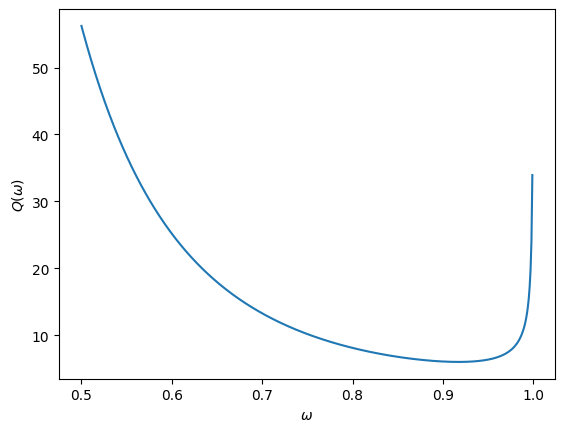

In [39]:
a=plt.plot(omega2family,np.multiply(omega2family,charge2))
plt.xlabel(r'$\omega$')
plt.ylabel(r'$Q(\omega)$')
plt.savefig("charge1875.pdf")
plt.show()

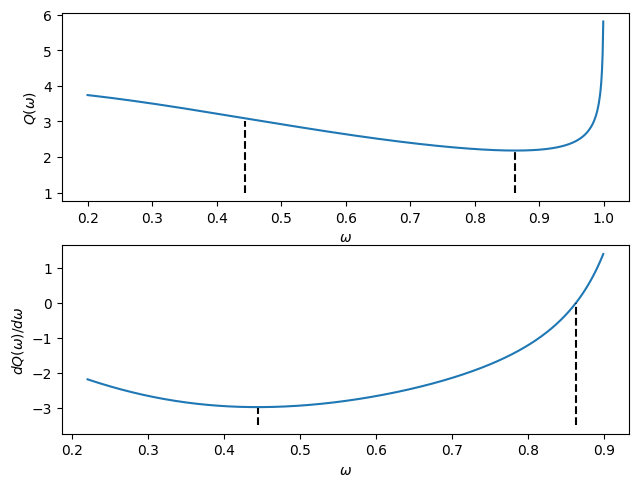

In [15]:
step=0.001
dcharge=np.zeros(charge.shape)
dcharge[0]=(-3*charge[0]+4*charge[1]-charge[2])/(2*step)
dcharge[1]=(-charge[3]+6*charge[2]-3*charge[1]-2*charge[0])/(6*step)
dcharge[-1]=(-3*charge[-1]+4*charge[-2]-charge[-3])/(2*step)
dcharge[-2]=(-charge[-4]+6*charge[-3]-3*charge[-2]-2*charge[-1])/(6*step)
for i in range(2,charge.size-2):
    dcharge[i]=(-charge[i+2]+8*charge[i+1]-8*charge[i-1]+charge[i-2])/(12*step)
dcharge2=np.zeros(charge2.shape)
dcharge2[0]=(-3*charge2[0]+4*charge2[1]-charge2[2])/(2*step)
dcharge2[1]=(-charge2[3]+6*charge2[2]-3*charge2[1]-2*charge2[0])/(6*step)
dcharge2[-1]=(-3*charge2[-1]+4*charge2[-2]-charge2[-3])/(2*step)
dcharge2[-2]=(-charge2[-4]+6*charge2[-3]-3*charge2[-2]-2*charge2[-1])/(6*step)
for i in range(2,charge2.size-2):
    dcharge2[i]=(-charge2[i+2]+8*charge2[i+1]-8*charge2[i-1]+charge2[i-2])/(12*step)
fig, (a1, a2) = plt.subplots(2)
fig.tight_layout()
a1.plot(omegafamily,charge)
a1.vlines(omegafamily[136],1.0,2.2,colors='k',linestyles= 'dashed')
a1.vlines(omegafamily[555],1.0,3.,colors='k',linestyles= 'dashed')
a1.set(xlabel=r'$\omega$', ylabel=r'$Q(\omega)$')
a2.plot(omegafamily[100:-20],-dcharge[100:-20])
a2.vlines(omegafamily[136],-3.5,0,colors='k',linestyles= 'dashed')
a2.vlines(omegafamily[555],-3.5,-3.,colors='k',linestyles= 'dashed')
a2.set(xlabel=r'$\omega$', ylabel=r'$dQ(\omega)/d\omega$')
fig.savefig("2chargedcharge1000.pdf",bbox_inches="tight")
plt.show()

In [36]:

print(omegafamily[136],omegafamily[400])

0.863 0.599


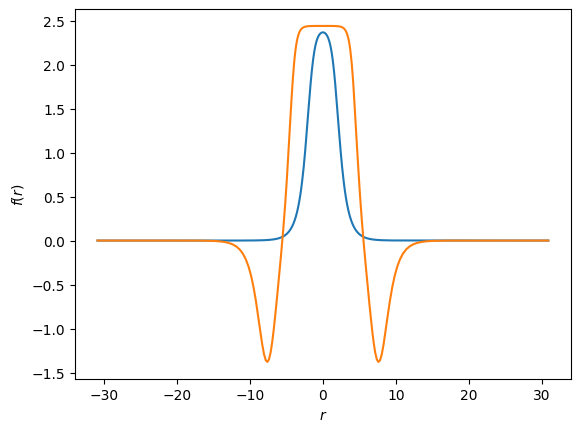

In [41]:
a=plt.plot(grid[10:-10],-evenidct(solfamily[400])[10:-10])
a=plt.plot(grid[10:-10],evenidct(solfamily2[400])[10:-10])
plt.xlabel(r'$r$')
plt.ylabel(r'$f(r)$')
plt.savefig("plots1500.pdf")
plt.show()

In [55]:
print(omega2family[199])

0.8


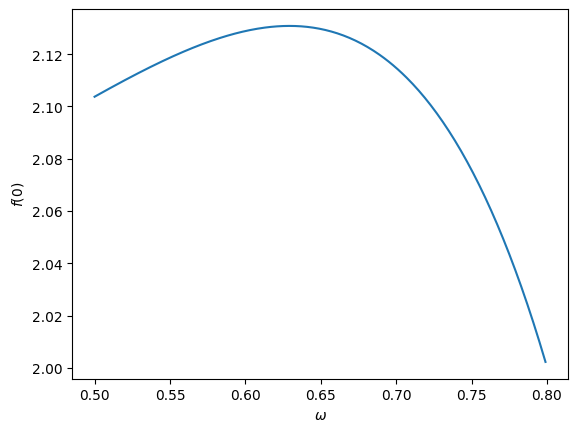

0.5 2.1037232427687393


In [20]:
sumvec=np.ones(42)
sumvec[1::2]*=-1
sumvec[0]=0.5
peakvalue=np.matmul(-sol2family,sumvec)
peakvalue*=2
a=plt.plot(omega2family[200:],peakvalue[200:])
plt.xlabel(r'$\omega$')
plt.ylabel(r'$f(0)$')
plt.savefig("peakvalue1875.pdf")
plt.show()
print(omega2family[499],peakvalue[499])

In [129]:
print(omegafamily[136],omegafamily[555])

0.863 0.444


In [19]:
print(omegafamily2[-5])
scipy.sparse.linalg.eigs(Lminus(solfamily2[-5],omegafamily2[-5],0.1,Ns),k=4,which='SM',maxiter=300000)[0]

0.20400000000000001


array([-5.38237508e-14+0.j,  9.58502569e-01+0.j,  9.59263998e-01+0.j,
        9.61485422e-01+0.j])

In [61]:
eigenvalues=np.zeros((omega2family.size,10))+1j*np.zeros((omega2family.size,10))
for i in range(0,omega2family.size):
    tmp=Lplus(sol2family[i],omega2family[i],0.1875,30)
    eigenvalues[i,:]=scipy.sparse.linalg.eigs(tmp,k=10,which='SM',maxiter=300000)[0]
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [62]:
np.savetxt('res/eigenvalueslplus1875.txt',eigenvalues) 
#print(eigenvalues[0:20])

In [174]:
eigenvalues.shape

(800, 10)

In [193]:
tmp=Hamiltonian(solfamily[70],omegagrid[70],0.1875,34)
scipy.sparse.linalg.eigs(tmp,k=2,which='SM',maxiter=200000)[0]

array([-2.1890593e-14+9.27094866e-08j, -2.1890593e-14-9.27094866e-08j])

In [136]:
omegagrid[60]

0.69

In [137]:
solfamily[60]

array([-7.79118042e-01,  5.73576728e-01, -1.88107082e-01, -3.40513371e-02,
        5.43154147e-02, -1.54435854e-02, -5.15739355e-03,  6.67879695e-03,
       -2.15830716e-03, -7.26693125e-04,  9.57505485e-04, -3.23356525e-04,
       -9.84940750e-05,  1.46013985e-04, -5.06512262e-05, -1.33188974e-05,
        2.27610841e-05, -8.28432080e-06, -1.86041614e-06,  3.54842792e-06,
       -1.41331970e-06, -2.76408310e-07,  5.48608226e-07, -2.47548618e-07,
       -4.23475540e-08,  8.54072183e-08, -4.26846481e-08, -5.56539959e-09,
        1.41729301e-08, -6.70472740e-09, -1.89309564e-10,  2.70307942e-09,
       -8.34429825e-10,  2.19711232e-10,  5.76041033e-10, -6.42434822e-11,
        8.29198213e-11,  1.08820155e-10, -1.21222486e-11,  6.38352612e-12,
        6.17682852e-12, -1.42113735e-11, -9.63274043e-12, -8.03466272e-12,
       -9.40479554e-12, -6.72081678e-12, -4.90599103e-12, -3.86940191e-12,
       -2.46360033e-12, -1.49037306e-12, -8.61515029e-13, -3.40902558e-13,
       -2.01257571e-14,  

In [256]:
def g2(x):
    #return 1.75/(np.cosh(x))
    #return 4/np.cosh(0.5*x)-2.4/np.cosh(0.25*x)
    return 2/np.cosh(x)-1/np.cosh(x-5)-1/np.cosh(x+5)

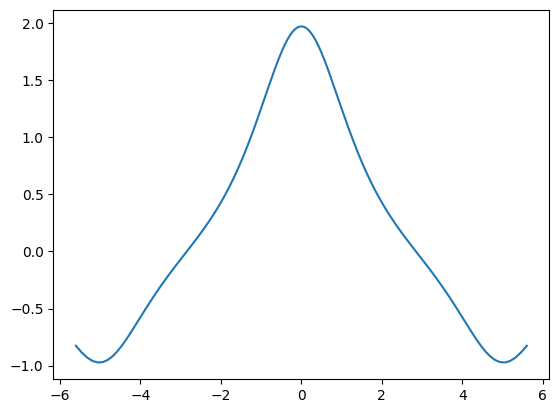

In [257]:
a=plt.plot(grid[50:-50],g2(grid)[50:-50])
plt.show()

2.0160525785047106e-15


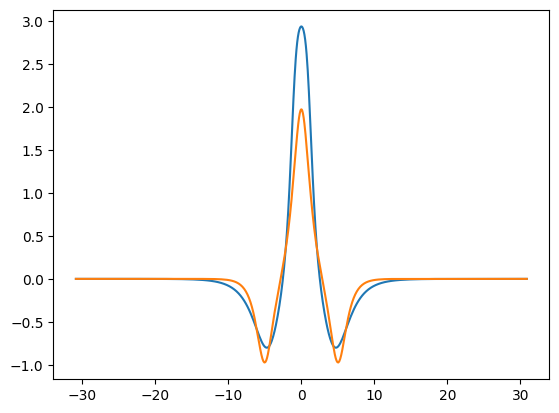

In [258]:
cvec=newton(evendct(g2(grid)),0.9,0.1,14)
print(cvec[1])
cgrid=evenidct(cvec[0])
a=plt.plot(grid[10:-10],cgrid[10:-10])
a=plt.plot(grid[10:-10],g2(grid)[10:-10])
plt.show()

In [259]:
c2vec=newton(cvec[0],0.9,0.12,8)
c21vec=newton(c2vec[0],0.9,0.14,8)
c22vec=newton(c21vec[0],0.9,0.16,8)
c23vec=newton(c22vec[0],0.9,0.1875,8)

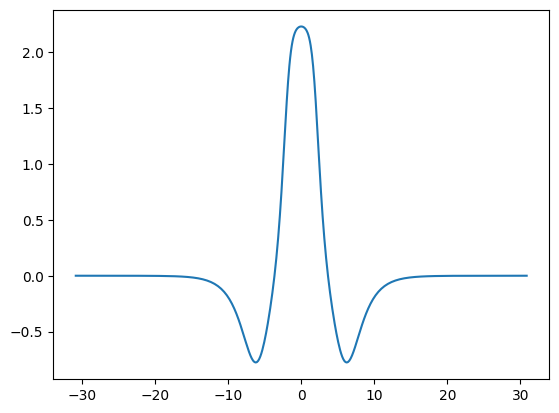

In [260]:
a=plt.plot(grid[10:-10],evenidct(c23vec[0])[10:-10])
plt.show()

In [406]:
c31vec=newton(c23vec[0],0.94,0.1875,10)
c32vec=newton(c31vec[0],0.96,0.1875,10)
c33vec=newton(c32vec[0],0.98,0.1875,14)
c3vec=newton(c33vec[0],0.99,0.1875,14)

In [273]:
cvec41=newton(cvec[0],0.92,0.1,14)
cvec42=newton(cvec41[0],0.95,0.1,14)
cvec43=newton(cvec42[0],0.96,0.1,14)
cvec44=newton(cvec43[0],0.97,0.1,14)
cvec45=newton(cvec44[0],0.98,0.1,14)


In [280]:
cvec46=newton(cvec45[0],0.985,0.1,14)
cvec47=newton(cvec46[0],0.99,0.1,14)
cvec48=newton(cvec47[0],0.992,0.1,14)

In [315]:
cvec481=newton(cvec48[0],0.994,0.1,20)
cvec482=newton(cvec481[0],0.995,0.1,20)
cvec483=newton(cvec482[0],0.996,0.1,20)
cvec484=newton(cvec483[0],0.997,0.1,20)
cvec485=newton(cvec484[0],0.9975,0.1,20)
cvec486=newton(cvec485[0],0.998,0.1,20)
cvec487=newton(cvec486[0],0.9985,0.1,20)
cvec488=newton(cvec487[0],0.999,0.1,20)

In [352]:
cvec489=newton(cvec488[0],0.999,0.12,20)
cvec49=newton(cvec489[0],0.999,0.14,20)
cvec491=newton(cvec49[0],0.999,0.15,20)

In [360]:
cvec492=newton(cvec491[0],0.9985,0.15,20)
cvec493=newton(cvec492[0],0.998,0.15,20)
cvec494=newton(cvec493[0],0.997,0.15,20)

In [363]:
print(cvec491[1])

7.273509691511744e-17


In [364]:
size=500
omega0=0.999
step=0.001
solfamily=np.zeros((size,Ns))
omegafamily = np.zeros(size)
solerr=np.zeros(size)
solfamily[0,:]=cvec491[0]
omegafamily[0]=omega0
solerr[0]=cvec491[1]
solfamily[1,:]=cvec493[0]
omegafamily[1]=omega0-step
solerr[1]=cvec493[1]
solfamily[2,:]=cvec494[0]
omegafamily[2]=omega0-2*step
solerr[2]=cvec494[1]
size=498
omega0=0.997
for i in range(0,size-1):
    tmp=newton(solfamily[i+2,:],omega0-step*(i+1),0.15,20)
    solfamily[i+3,:]=tmp[0]
    omegafamily[i+3]=omega0-step*(i+1)
    solerr[i+3]=tmp[1]
    print(i,omegafamily[i+3],tmp[1])

0 0.996 1.524295506842478e-16
1 0.995 1.8949170323807053e-16
2 0.994 2.551416749746562e-16
3 0.993 3.546352748095243e-16
4 0.992 2.690077906352498e-16
5 0.991 2.8047578615741676e-16
6 0.99 3.0559703690293264e-16
7 0.989 4.1459219941242716e-16
8 0.988 3.8494042964162214e-16
9 0.987 3.600529933182539e-16
10 0.986 3.2465314328378714e-16
11 0.985 4.456002624049517e-16
12 0.984 3.862141468948869e-16
13 0.983 4.711860530923263e-16
14 0.982 5.0459788078197005e-16
15 0.981 6.993962781746563e-16
16 0.98 4.3431544721393523e-16
17 0.979 5.294378127558961e-16
18 0.978 4.769458728534919e-16
19 0.977 4.139153384303242e-16
20 0.976 5.790509580284156e-16
21 0.975 6.356268179216506e-16
22 0.974 4.590066053458777e-16
23 0.973 7.015336448756886e-16
24 0.972 6.889266428017362e-16
25 0.971 7.612950705194795e-16
26 0.97 8.261351283095473e-16
27 0.969 6.36164047965123e-16
28 0.968 7.7371680673814285e-16
29 0.967 9.462311489988213e-16
30 0.966 5.449720673847572e-16
31 0.965 8.601081812151509e-16
32 0.964 5.72

248 0.748 2.4895209989931596e-15
249 0.747 2.8161920660866888e-15
250 0.746 2.9356035722216614e-15
251 0.745 2.782998802719331e-15
252 0.744 2.2900906315878046e-15
253 0.743 2.2394971565168915e-15
254 0.742 2.5338255532624163e-15
255 0.741 2.4561505832757632e-15
256 0.74 2.3257348672772986e-15
257 0.739 2.4646394328264983e-15
258 0.738 2.1294163826583453e-15
259 0.737 2.5924855299033587e-15
260 0.736 2.2196765838923443e-15
261 0.735 2.623157453216796e-15
262 0.734 2.3398958306460195e-15
263 0.733 2.44547522398903e-15
264 0.732 3.1557134663179913e-15
265 0.731 2.2768585732592375e-15
266 0.73 2.705908554807404e-15
267 0.729 3.382438488185777e-15
268 0.728 2.7309986244526925e-15
269 0.727 2.34018597908489e-15
270 0.726 2.621141277546774e-15
271 0.725 3.525043783331145e-15
272 0.724 2.219412445212758e-15
273 0.723 2.2532223936734266e-15
274 0.722 2.8695976554908734e-15
275 0.721 2.6750404637501754e-15
276 0.72 2.1299202322265493e-15
277 0.719 2.6428075533300182e-15
278 0.718 2.600717746467

477 0.5189999999999999 3.744765477637698e-15
478 0.518 2.9858447874215887e-15
479 0.517 3.901867793851935e-15
480 0.516 2.964251511353774e-15
481 0.515 2.4266541040168992e-15
482 0.514 3.294385266853034e-15
483 0.513 2.7949766201331606e-15
484 0.512 3.134965598765935e-15
485 0.511 3.4679060527359435e-15
486 0.51 2.681882667651534e-15
487 0.509 3.1518593192046496e-15
488 0.508 2.559757420035639e-15
489 0.507 3.11461318050493e-15
490 0.506 3.127030839662678e-15
491 0.505 3.1840518678543715e-15
492 0.504 3.0965120633300177e-15
493 0.503 3.103968987704212e-15
494 0.502 3.2122329348094574e-15
495 0.501 3.541504968859102e-15
496 0.5 3.2174185091933574e-15


In [366]:
np.savetxt('res/e1500/solfamily1500.txt',solfamily)
np.savetxt('res/e1500/solerr1500.txt',solerr)
np.savetxt('res/e1500/omegafamily1500.txt',omegafamily)

In [371]:
solerr[0:4]

array([7.27350969e-17, 1.14828296e-16, 1.78451197e-16, 1.52429551e-16])

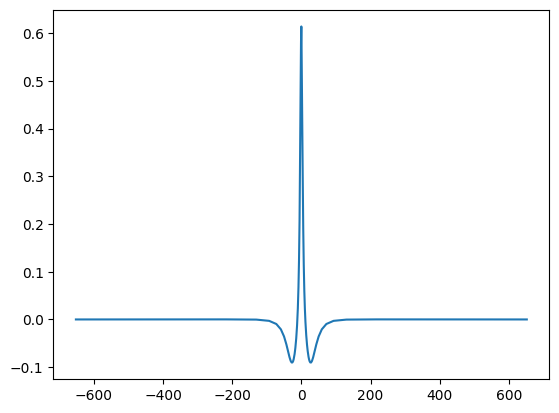

In [354]:
a=plt.plot(grid,evenidct(cvec491[0]))
plt.show()

In [408]:
print(c31vec[1],c32vec[1],c33vec[1],c3vec[1])

2.197150883084806e-15 1.5610705431606503e-15 8.907623284641952e-16 8.448464806484786e-16


In [84]:
f1vec=newton(b6vec[0],0.999,0.1675,12)
f2vec=newton(f1vec[0],0.999,0.15,12)
print(f2vec[1])

2.036893828521175e-17


In [85]:
size=500
omega0=0.999
step=0.001
solfamily=np.zeros((size,Ns))
omegafamily = np.zeros(size)
solerr=np.zeros(size)
solfamily[0,:]=f2vec[0]
omegafamily[0]=omega0
solerr[0]=f2vec[1]
for i in range(0,size-1):
    tmp=newton(solfamily[i,:],omega0-step*(i+1),0.15,14)
    solfamily[i+1,:]=tmp[0]
    omegafamily[i+1]=omega0-step*(i+1)
    solerr[i+1]=tmp[1]
    print(i,omegafamily[i+1],tmp[1])

0 0.998 1.3146509981967142e-17
1 0.997 1.550886084963214e-17
2 0.996 2.1281160271968038e-17
3 0.995 2.373634471136188e-17
4 0.994 2.1409724514325707e-17
5 0.993 3.485852770105824e-17
6 0.992 3.797806894289494e-17
7 0.991 5.391112731751496e-17
8 0.99 4.9703349083519415e-17
9 0.989 5.5307261282063584e-17
10 0.988 4.783095933814839e-17
11 0.987 6.851566051096452e-17
12 0.986 5.3213912644985366e-17
13 0.985 6.26348008963943e-17
14 0.984 1.353845228533703e-16
15 0.983 1.4288201018749202e-16
16 0.982 6.992048160384651e-17
17 0.981 8.936769128681404e-17
18 0.98 9.107068497741867e-17
19 0.979 8.949596721563819e-17
20 0.978 8.993201226790918e-17
21 0.977 1.046970813213851e-16
22 0.976 7.424852242487626e-17
23 0.975 1.2610867547882672e-16
24 0.974 1.615353457307982e-16
25 0.973 9.902873118986285e-17
26 0.972 9.271983795932434e-17
27 0.971 1.471286452283218e-16
28 0.97 1.6123702566079442e-16
29 0.969 1.700643906663885e-16
30 0.968 1.0416402229930106e-16
31 0.967 1.811000073570037e-16
32 0.966 1.6

251 0.747 6.217031614665853e-16
252 0.746 8.528424546790978e-16
253 0.745 1.0356694566686414e-15
254 0.744 7.208222577813829e-16
255 0.743 8.64028851029367e-16
256 0.742 7.59559915372924e-16
257 0.741 6.403290101416566e-16
258 0.74 1.0770840047912163e-15
259 0.739 7.905963919327838e-16
260 0.738 7.834825132178425e-16
261 0.737 8.408571805139646e-16
262 0.736 9.289734488473436e-16
263 0.735 1.4328659395256568e-15
264 0.734 8.799016729215958e-16
265 0.733 8.394598018193942e-16
266 0.732 8.839117155261021e-16
267 0.731 8.143435077723265e-16
268 0.73 1.0162473256907345e-15
269 0.729 9.842536088571947e-16
270 0.728 8.213871442530497e-16
271 0.727 7.798005935554753e-16
272 0.726 9.237222755322805e-16
273 0.725 1.1766679272228702e-15
274 0.724 8.735618228614713e-16
275 0.723 6.760796130292017e-16
276 0.722 7.180683909702222e-16
277 0.721 7.638607982819228e-16
278 0.72 1.4138465683320677e-15
279 0.719 8.988843355925303e-16
280 0.718 6.635071093311857e-16
281 0.717 9.768207081676446e-16
282 0.7

479 0.519 1.4388256076547183e-15
480 0.518 1.4295335751994535e-15
481 0.517 1.425230247634288e-15
482 0.516 1.5720899151961545e-15
483 0.515 1.6355619919997757e-15
484 0.514 1.88250895748724e-15
485 0.513 1.7705074214167454e-15
486 0.512 2.269477833911637e-15
487 0.511 1.6199779448454248e-15
488 0.51 1.7025625416399818e-15
489 0.509 1.3079390568339676e-15
490 0.508 1.4365689649883844e-15
491 0.507 2.139620035249877e-15
492 0.506 2.3951937818564444e-15
493 0.505 1.3360573652053124e-15
494 0.504 2.519442274687142e-15
495 0.503 1.7020035965156053e-15
496 0.502 1.6452663427187492e-15
497 0.501 1.405276926230968e-15
498 0.5 1.514052881919022e-15


In [86]:
np.savetxt('res/solfamily1500.txt',solfamily)
np.savetxt('res/solerr1500.txt',solerr)
np.savetxt('res/omegafamily1500.txt',omegafamily)

In [48]:
omegafamily.shape

(500,)

In [382]:
eigenvalues=np.zeros((300,24))+1j*np.zeros((300,24))
for i in range(0,300):
    tmp=Hamiltonian(solfamily[i],omegafamily[i],0.15,40)
    eigenvalues[i,:]=scipy.sparse.linalg.eigs(tmp,k=24,which='SM',maxiter=300000)[0]
    print(i,omegafamily[i])

0 0.499
1 0.498
2 0.497
3 0.496
4 0.495
5 0.494
6 0.493
7 0.492
8 0.491
9 0.49
10 0.489
11 0.488
12 0.487
13 0.486
14 0.485
15 0.484
16 0.483
17 0.482
18 0.481
19 0.48
20 0.479
21 0.478
22 0.477
23 0.476
24 0.475
25 0.474
26 0.473
27 0.472
28 0.471
29 0.47
30 0.469
31 0.46799999999999997
32 0.46699999999999997
33 0.46599999999999997
34 0.46499999999999997
35 0.46399999999999997
36 0.46299999999999997
37 0.462
38 0.461
39 0.46
40 0.459
41 0.458
42 0.457
43 0.456
44 0.455
45 0.454
46 0.453
47 0.452
48 0.451
49 0.45
50 0.449
51 0.448
52 0.447
53 0.446
54 0.445
55 0.444
56 0.443
57 0.442
58 0.441
59 0.44
60 0.439
61 0.438
62 0.437
63 0.436
64 0.435
65 0.434
66 0.433
67 0.432
68 0.431
69 0.43
70 0.429
71 0.428
72 0.427
73 0.426
74 0.425
75 0.424
76 0.423
77 0.422
78 0.421
79 0.42
80 0.419
81 0.418
82 0.417
83 0.416
84 0.415
85 0.414
86 0.413
87 0.412
88 0.41100000000000003
89 0.41000000000000003
90 0.40900000000000003
91 0.40800000000000003
92 0.40700000000000003
93 0.406
94 0.405
95 0.404


In [383]:
np.savetxt('res/e1500/eigenvalues1500_21.txt',eigenvalues) 

In [421]:
def g3(x):
    #return 1.75/(np.cosh(x))
    #return 4/np.cosh(0.5*x)-2.4/np.cosh(0.25*x)
    return 4.5/np.cosh(x)-1.2/np.cosh(0.5*x-1.5)-1.2/np.cosh(0.5*x+1.5)#+0.8/np.cosh(x-8)+0.8/np.cosh(x+8)
def g4(x):
    #return 1.75/(np.cosh(x))
    #return 4/np.cosh(0.5*x)-2.4/np.cosh(0.25*x)
    return 7/np.cosh(3*x)-0.8/np.cosh(0.7*x+1.925)-0.8/np.cosh(0.7*x-1.925)#+0.4/np.cosh(x-5)+0.4/np.cosh(x+5)

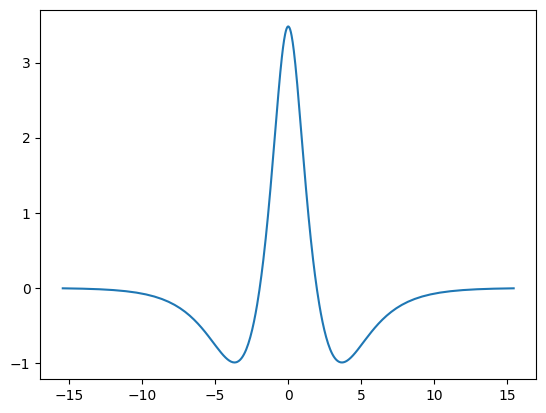

In [410]:
a=plt.plot(grid[10:-10],g3(grid)[10:-10])
plt.show()

In [411]:
dvec=newton(evendct(g3(grid)),0.9,0.03,14)

7.28792270855097e-15


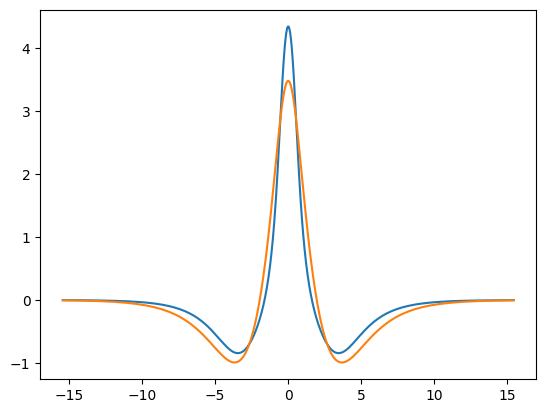

In [412]:
print(dvec[1])
dgrid=evenidct(dvec[0])
a=plt.plot(grid[10:-10],dgrid[10:-10])
a=plt.plot(grid[10:-10],g3(grid)[10:-10])
plt.show()

2.0004737579005482e-14


/var/folders/4l/pw8phgbn65n48yncrkgs06ym0000gr/T/ipykernel_6938/160997446.py:8: RuntimeWarning: overflow encountered in cosh
  return 7/np.cosh(3*x)-0.8/np.cosh(0.7*x+1.925)-0.8/np.cosh(0.7*x-1.925)+0.4/np.cosh(x-7)+0.4/np.cosh(x+7)


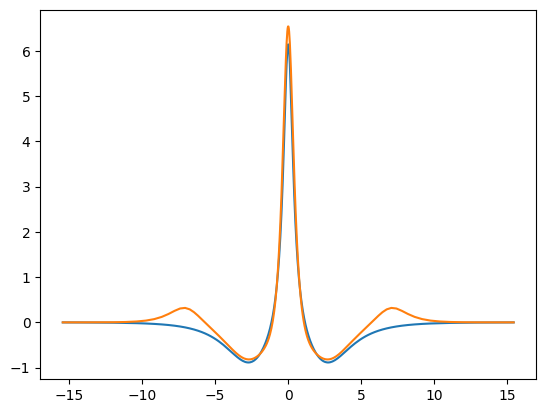

In [413]:
d1vec=newton(dvec[0],0.9,0.02,10)
d12vec=newton(d1vec[0],0.9,0.01,10)
d2vec=newton(d12vec[0],0.9,0.0,10)

print(d2vec[1])
d2grid=evenidct(d2vec[0])
a=plt.plot(grid[10:-10],d2grid[10:-10])
a=plt.plot(grid[10:-10],g4(grid)[10:-10])
plt.show()

/var/folders/4l/pw8phgbn65n48yncrkgs06ym0000gr/T/ipykernel_6938/1518703793.py:8: RuntimeWarning: overflow encountered in cosh
  return 7/np.cosh(3*x)-0.8/np.cosh(0.7*x+1.925)-0.8/np.cosh(0.7*x-1.925)#+0.4/np.cosh(x-5)+0.4/np.cosh(x+5)


4.6640456079466336e-14


/var/folders/4l/pw8phgbn65n48yncrkgs06ym0000gr/T/ipykernel_6938/1518703793.py:8: RuntimeWarning: overflow encountered in cosh
  return 7/np.cosh(3*x)-0.8/np.cosh(0.7*x+1.925)-0.8/np.cosh(0.7*x-1.925)#+0.4/np.cosh(x-5)+0.4/np.cosh(x+5)


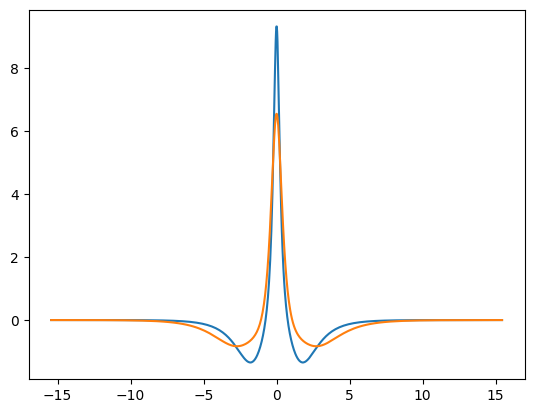

In [428]:
d21vec=newton(evendct(g4(grid)),0.86,0.,10)
d22vec=newton(d21vec[0],0.8,0.,10)
d23vec=newton(d22vec[0],0.75,0.,10)
print(d23vec[1])
d21grid=evenidct(d23vec[0])
a=plt.plot(grid[10:-10],d21grid[10:-10])
a=plt.plot(grid[10:-10],g4(grid)[10:-10])
plt.show()

In [41]:
solfamily=np.loadtxt('res/g1875/solfamily1875.txt') 
solerr=np.loadtxt('res/g1875/solerr1875.txt') 
omegafamily=np.loadtxt('res/g1875/omegafamily1875.txt')

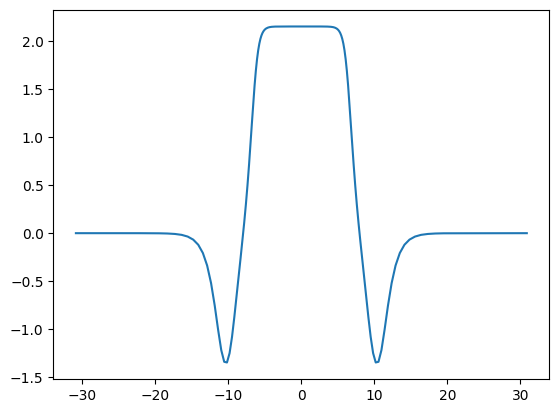

In [75]:
a=plt.plot(grid[10:-10],evenidct(e1solfamily[-130])[10:-10])
plt.show()

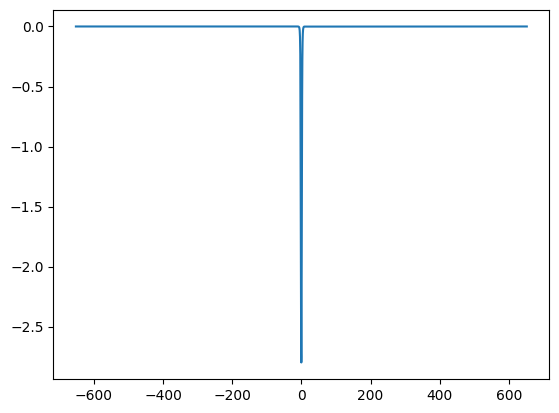

In [374]:
test=newton(solfamily[-1],0.499,0.15,14)

In [375]:
print(test[1],lg.norm(solfamily[-1]-test[0]))

3.4552763127411965e-15 0.004533129496680508


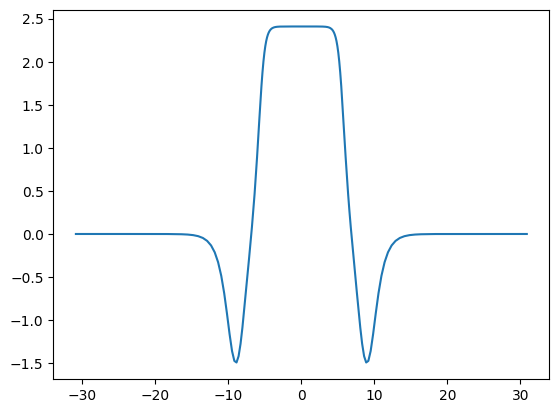

In [377]:
d1000grid=evenidct(test[0])
a=plt.plot(grid[10:-10],d1000grid[10:-10])
plt.show()

In [378]:
size=300
omega0=0.499
step=0.001
solfamily=np.zeros((size,Ns))
omegafamily = np.zeros(size)
solerr=np.zeros(size)
solfamily[0,:]=test[0]
omegafamily[0]=omega0
solerr[0]=test[1]
for i in range(0,size-1):
    tmp=newton(solfamily[i,:],omega0-step*(i+1),0.15,20)
    solfamily[i+1,:]=tmp[0]
    omegafamily[i+1]=omega0-step*(i+1)
    solerr[i+1]=tmp[1]
    print(i,omegafamily[i+1],tmp[1])

0 0.498 3.103208434779906e-15
1 0.497 3.3514442788573925e-15
2 0.496 2.7587689800643926e-15
3 0.495 3.537657449328389e-15
4 0.494 2.7073158681292652e-15
5 0.493 2.7852716615325486e-15
6 0.492 3.9066188177494664e-15
7 0.491 3.342660751767802e-15
8 0.49 4.574114917184537e-15
9 0.489 3.423055917899642e-15
10 0.488 3.4412047430931125e-15
11 0.487 4.070695749454329e-15
12 0.486 3.038376715051436e-15
13 0.485 4.429193796989932e-15
14 0.484 3.207521656690922e-15
15 0.483 3.6554521306435246e-15
16 0.482 3.4380820153841067e-15
17 0.481 3.607857451434578e-15
18 0.48 2.6004873414759208e-15
19 0.479 2.967821989166617e-15
20 0.478 3.382427997715613e-15
21 0.477 3.279076969459096e-15
22 0.476 2.8439235022790953e-15
23 0.475 3.003608132080128e-15
24 0.474 3.381136750453711e-15
25 0.473 2.996889892377578e-15
26 0.472 3.1327654475523143e-15
27 0.471 3.667504203310089e-15
28 0.47 3.056716960232946e-15
29 0.469 3.1189313203407695e-15
30 0.46799999999999997 3.439767694852472e-15
31 0.46699999999999997 2.7

241 0.257 4.3485899794621135e-15
242 0.256 3.7271999824695175e-15
243 0.255 3.034446980592642e-15
244 0.254 3.779667527466477e-15
245 0.253 3.931343617272483e-15
246 0.252 3.6252465236615935e-15
247 0.251 4.548226330264067e-15
248 0.25 3.674179956518185e-15
249 0.249 4.074986608284263e-15
250 0.248 4.8025732920858615e-15
251 0.247 3.571047220855815e-15
252 0.246 4.214443599481765e-15
253 0.245 3.2965729387012795e-15
254 0.244 3.9579821650164904e-15
255 0.243 3.2833414199395156e-15
256 0.242 4.418318776156347e-15
257 0.241 4.391656936350249e-15
258 0.24 3.751450304331573e-15
259 0.239 3.4338368803439343e-15
260 0.238 5.2789481088571755e-15
261 0.237 3.490648316980829e-15
262 0.236 3.2893447807546143e-15
263 0.235 4.080129385982789e-15
264 0.23399999999999999 3.76805036691069e-15
265 0.23299999999999998 3.714260937086688e-15
266 0.23199999999999998 4.683637395401404e-15
267 0.23099999999999998 3.833209493842379e-15
268 0.22999999999999998 4.341504473784384e-15
269 0.22899999999999998 3.8

In [379]:
np.savetxt('res/e1500/solfamily1500_2.txt',solfamily)
np.savetxt('res/e1500/solerr1500_2.txt',solerr)
np.savetxt('res/e1500/omegafamily1500_2.txt',omegafamily)

In [236]:
def gh(x):
    return 2.2/np.cosh(0.05*x*x)
def gh2(x):
    return 3/np.cosh(x)

In [237]:
testb1=newton(evendct(gh2(grid)),0.6,0.1,14)
testb2=newton(testb1[0],0.6,0.12,14)
testb3=newton(testb2[0],0.6,0.14,14)
testb4=newton(testb3[0],0.5,0.14,14)
testb5=newton(testb4[0],0.5,0.145,14)
testb6=newton(testb5[0],0.5,0.15,14)
for i in range(1,30)

In [244]:
0.0375/0.0005

75.0

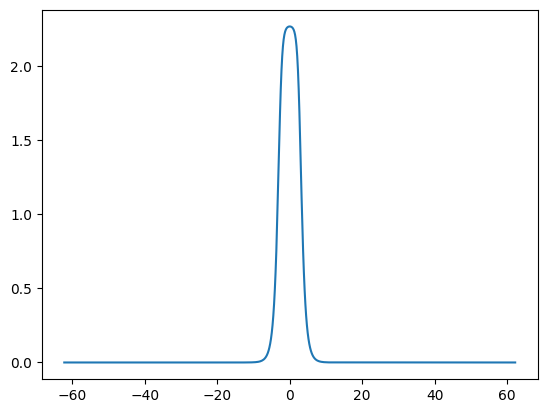

In [215]:
a=plt.plot(grid[20:-20],evenidct(testb9[0])[20:-20])
#b=plt.plot(grid[10:-10],gh2(grid)[10:-10])
plt.show()

In [317]:
3./16.

0.1875